# Phaser

In [1]:
# Setup
from scipy.io import wavfile
import numpy as np
import sounddevice as sd
import soundfile as sf
import matplotlib.pyplot as plt
from scipy import signal
import sys
import requests
import io

# URL of the raw wave file on GitHub
# un-comment the URL of the file you want to use
# ATF Drums
#github_url = "https://raw.githubusercontent.com/kevbrnen/Music-Technology-Final-Project/main/Sound%20Examples/Testing_Files/Around%20the%20fur%20drums.wav"
# KYW inst
github_url = "https://raw.githubusercontent.com/kevbrnen/Music-Technology-Final-Project/main/Sound%20Examples/Testing_Files/KYW%20Inst.wav"

# Fetch the wave file from GitHub
response = requests.get(github_url)

# Check if the request was successful
if response.status_code == 200:
    # Read the wave data from the response content
    wave_data = io.BytesIO(response.content)
    
    # Read the wave file 
    fs, data = wavfile.read(wave_data)
    
else:
    print("Failed to fetch the wave file from GitHub")


# Get the bit depth of the audio data (assumes audio_data is a NumPy array)
bit_depth = data.dtype.itemsize * 8

# Calculate the scaling factor for normalization
scaling_factor = 2 ** (bit_depth - 1)  # For signed audio

# Convert audio data to floating-point values and normalize
data = data.astype(np.float32) / scaling_factor

# Verify that the data is now in the range -1 to 1
print(f"Min Value: {np.min(data)}")
print(f"Max Value: {np.max(data)}")

Min Value: -0.9484677314758301
Max Value: 0.9998999834060669


# Time Variant Grey Box Modelling of a Phaser Pedal
Roope Kiiski ,Fabián Esqueda and Vesa Välimäki

In [2]:
sd.play(data, fs)

In [2]:
#Allpass equation = Y(n) = a1*x(n) + x(n-1) - a1*y(n-1)

fc = 1000  #Center Frequency

# a1 coefficient for allpass equation
a1 = (np.tan(np.pi * fc/fs) - 1)/(np.tan(np.pi * fc/fs) + 1)

speed = 0.5 #speed of LFO in Hz

amplitude = 1

# Determines how far apart allpass cutoff frequencies are from each other
intensity = 4
if(intensity == 1):
    variance = 250
elif(intensity == 2):
    variance = 500
elif(intensity == 3):
    variance = 750
elif(intensity == 4):
    variance = 1000

#Temporary variables
y_1_1 = 0
y_1 = 0
y_2_1 = 0
y_2 = 0
y_3_1 = 0
y_3 = 0
y_4_1 = 0
y_4 = 0
y_5_1 = 0
y_5 = 0
y_6_1 = 0
y_6 = 0
y_7_1 = 0
y_7 = 0
y_8_1 = 0
y_8 = 0

# Processing loop
The phaser works by combining the outputs of allpass filters with different cutoff frequencies. This creates a comb filtering effect on the original signal. If we add an LFO, we can alter the cutoff frequencies of each allpass filter. When the dry and wet signals are recombined, the phasing effect can be heard.
This method of processing probably wont work too well in real time, but I will explore different ways it can be implemented to find what works the best.

In [3]:
output = np.zeros((len(data), 2))
for i in range(1,len(data)):

    #Calculate LFO value for this sample
    t = i/fs
    lfo_val = amplitude * np.sin(2 * np.pi * speed * t)


    #APF 1
    a1_1 = (np.tan(np.pi * (fc + (lfo_val * variance))/fs)-1) / (np.tan(np.pi * (fc + (lfo_val * variance))/fs) + 1)
    y_1_1= y_1
    y_1 = (a1_1 * data[i]) + data[i-1] - (a1_1 * y_1_1)

    #APF 2
    a1_2 = (np.tan(np.pi * ((fc + variance) + (lfo_val * variance))/fs)-1) / (np.tan(np.pi * ((fc + variance) + (lfo_val * variance))/fs) + 1)
    y_2_1 = y_2
    y_2 = (a1_2 * y_1) + y_1_1 - (a1_2 * y_2_1)

    #APF 3
    a1_3 = (np.tan(np.pi * ((fc + (variance*2)) + (lfo_val * variance))/fs)-1) / (np.tan(np.pi * ((fc + (variance*2)) + (lfo_val * variance))/fs) + 1)
    y_3_1 = y_3
    y_3 = (a1_3 * y_2) + y_2_1 - (a1_3 * y_3_1)

    #APF 4
    a1_4 = (np.tan(np.pi * ((fc + (variance*3)) + (lfo_val * variance))/fs)-1) / (np.tan(np.pi * ((fc + (variance*3)) + (lfo_val * variance))/fs) + 1)
    y_4_1 = y_4
    y_4 = (a1_4 * y_3) + y_3_1 - (a1_4 * y_4_1)

    #APF 5
    a1_5 = (np.tan(np.pi * ((fc + (variance*4)) + (lfo_val * variance))/fs)-1) / (np.tan(np.pi * ((fc + (variance*4)) + (lfo_val * variance))/fs) + 1)
    y_5_1 = y_5
    y_5 = (a1_5 * y_4) + y_4_1 - (a1_5 * y_5_1)

    #APF 6
    a1_6 = (np.tan(np.pi * ((fc + (variance*5)) + (lfo_val * variance))/fs)-1) / (np.tan(np.pi * ((fc + (variance*5)) + (lfo_val * variance))/fs) + 1)
    y_6_1 = y_6
    y_6 = (a1_6 * y_5) + y_5_1 - (a1_6 * y_6_1)

    #APF 7
    a1_7 = (np.tan(np.pi * ((fc + (variance*6)) + (lfo_val * variance))/fs)-1) / (np.tan(np.pi * ((fc + (variance*6)) + (lfo_val * variance))/fs) + 1)
    y_7_1 = y_7
    y_7 = (a1_7 * y_6) + y_6_1 - (a1_7 * y_7_1)

    #APF 8
    a1_8 = (np.tan(np.pi * ((fc + (variance*7)) + (lfo_val * variance))/fs)-1) / (np.tan(np.pi * ((fc + (variance*7)) + (lfo_val * variance))/fs) + 1)
    y_8_1 = y_8
    y_8 = (a1_8 * y_7) + y_7_1 - (a1_8 * y_7_1)

    output[i] = y_8



In [4]:
phaser_out = np.column_stack((output[:,0] + data[:,0], output[:,1] + data[:,1]))

In [60]:
sd.play(phaser_out, fs)

Text(0.5, 1.0, 'Original Signal')

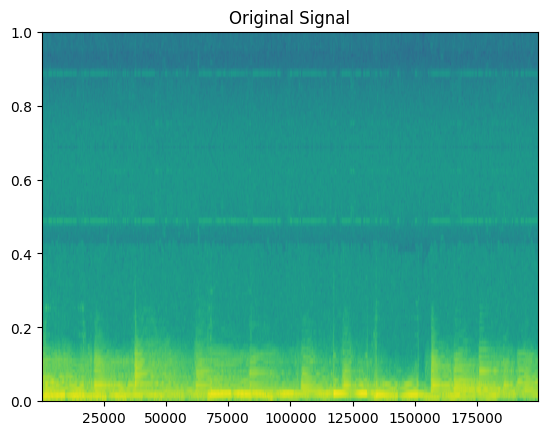

In [9]:
plt.specgram(data[1000:400000, 1])
plt.title("Original Signal")

Text(0.5, 1.0, 'Phase Shifted Signal')

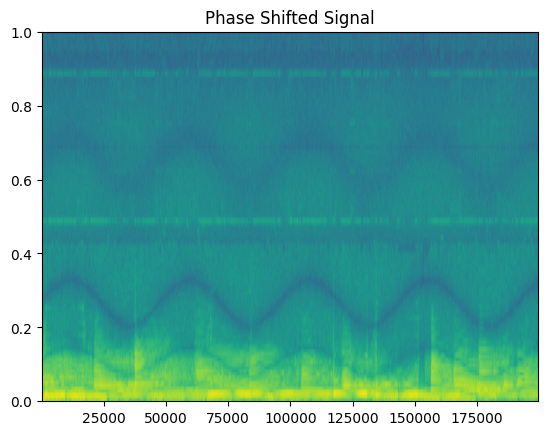

In [10]:
plt.specgram(phaser_out[1000:400000,1])
plt.title("Phase Shifted Signal")